In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/strawberry')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 83.5M/83.5M [00:04<00:00, 18.2MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "strawberry/Strawberry/train",
    label_mode="categorical",
    class_names=['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "strawberry/Strawberry/valid",
    label_mode="categorical",
    class_names=['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 3598 files belonging to 2 classes.
==========================Validation Data====================
Found 900 files belonging to 2 classes.


In [6]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("strawberry/Strawberry/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("strawberry/Strawberry/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 3598 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


In [7]:

# Check GPU
!nvidia-smi

Sun Jun  4 12:22:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

In [11]:

# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Strawberry_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [12]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                           

In [13]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.69889, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 86s 260ms/step - loss: 0.2201 - accuracy: 0.9814 - val_loss: 6.2418 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9922
Epoch 2: val_accuracy improved from 0.69889 to 0.90889, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 43s 237ms/step - loss: 0.0470 - accuracy: 0.9922 - val_loss: 0.2826 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9947
Epoch 3: val_accuracy did not improve from 0.90889
180/180 [==============================] - 18s 101ms/step - loss: 0.0275 - accuracy: 0.9947 - val_loss: 1.7883 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 4/100
180/180 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9981
Epoch 4: val_accuracy improved from 0.90889 to 0.94000, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 43s 240ms/step - loss: 0.0110 - accuracy: 0.9981 - val_loss: 0.4715 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/100
180/180 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9950
Epoch 5: val_accuracy did not improve from 0.94000
180/180 [==============================] - 18s 102ms/step - loss: 0.0455 - accuracy: 0.9950 - val_loss: 1.4437 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 6/100
180/180 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9994
Epoch 6: val_accuracy improved from 0.94000 to 0.98000, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 44s 243ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.2486 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/100
180/180 [==============================] - ETA: 0s - loss: 9.5140e-04 - accuracy: 0.9997
Epoch 7: val_accuracy improved from 0.98000 to 0.98333, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 42s 236ms/step - loss: 9.5140e-04 - accuracy: 0.9997 - val_loss: 0.1970 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 8/100
180/180 [==============================] - ETA: 0s - loss: 2.1700e-05 - accuracy: 1.0000
Epoch 8: val_accuracy improved from 0.98333 to 0.98667, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 43s 242ms/step - loss: 2.1700e-05 - accuracy: 1.0000 - val_loss: 0.1323 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 9/100
180/180 [==============================] - ETA: 0s - loss: 7.4267e-06 - accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.98667 to 0.99222, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 43s 237ms/step - loss: 7.4267e-06 - accuracy: 1.0000 - val_loss: 0.0739 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 10/100
180/180 [==============================] - ETA: 0s - loss: 1.1477e-05 - accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.99222 to 0.99667, saving model to Strawberry_MobileNetV2_model1_Based_Non_Augmented


180/180 [==============================] - 43s 240ms/step - loss: 1.1477e-05 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 11/100
180/180 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9997
Epoch 11: val_accuracy did not improve from 0.99667
180/180 [==============================] - 18s 102ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0573 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 12/100
180/180 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9964
Epoch 12: val_accuracy did not improve from 0.99667
180/180 [==============================] - 19s 106ms/step - loss: 0.0190 - accuracy: 0.9964 - val_loss: 0.9867 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 13/100
180/180 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9956
Epoch 13: val_accuracy did not improve from 0.99667
180/180 [==============================] - 19s 103ms/step - loss: 0.0318 - accuracy: 0.9956 - val_loss: 0

180/180 [==============================] - 44s 242ms/step - loss: 0.0083 - accuracy: 0.9989 - val_loss: 6.9666e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/100
180/180 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994
Epoch 17: val_accuracy did not improve from 1.00000
180/180 [==============================] - 18s 102ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 1.6402e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 18/100
180/180 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9983
Epoch 18: val_accuracy did not improve from 1.00000
180/180 [==============================] - 19s 107ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 1.2779e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/100
180/180 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9992
Epoch 19: val_accuracy did not improve from 1.00000
180/180 [==============================] - 18s 102ms/step - loss: 0.0036 - accuracy: 

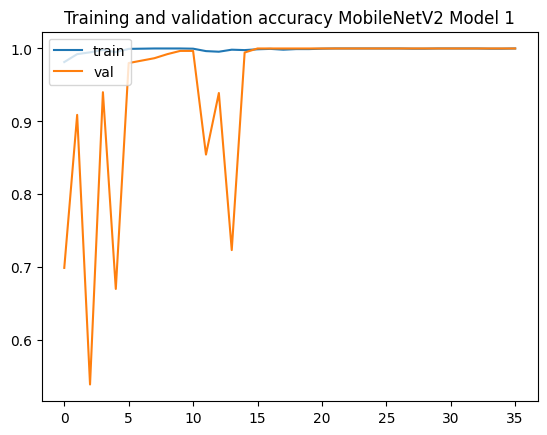

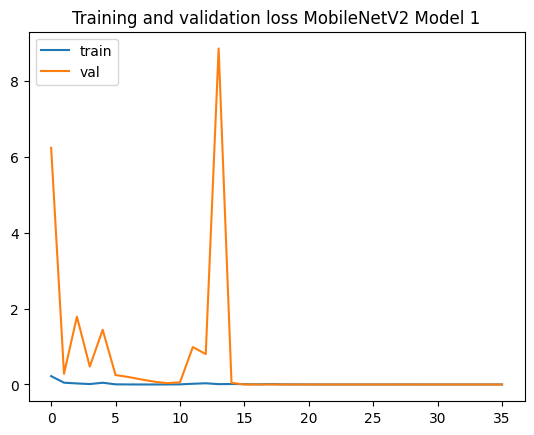

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [18]:
!zip -r /content/Strawberry_MobileNetV2_model1_Based_Non_Augmented.zip /content/Strawberry_MobileNetV2_model1_Based_Non_Augmented

  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model1_Based_Non_Augmented/saved_model.pb (deflated 91%)


In [19]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Strawberry_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [20]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2,586,434
Trainable params: 2,552,322
No

In [21]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
180/180 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9858
Epoch 1: val_accuracy improved from -inf to 0.92556, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 74s 254ms/step - loss: 0.0407 - accuracy: 0.9858 - val_loss: 2.3541 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9931
Epoch 2: val_accuracy did not improve from 0.92556
180/180 [==============================] - 22s 120ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 1.8858 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9975
Epoch 3: val_accuracy did not improve from 0.92556
180/180 [==============================] - 19s 104ms/step - loss: 0.0154 - accuracy: 0.9975 - val_loss: 0.9374 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 4/100
180/180 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9936
Epoch 4: val_accuracy did not improve from 0.92556
180/180 [==============================] - 19s 108ms/step - loss: 0.0352 - accuracy: 0.9936 - val_loss: 7.5414 - va

180/180 [==============================] - 42s 236ms/step - loss: 6.4288e-05 - accuracy: 1.0000 - val_loss: 1.0202 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 8/100
180/180 [==============================] - ETA: 0s - loss: 4.3806e-05 - accuracy: 1.0000
Epoch 8: val_accuracy improved from 0.94556 to 0.96667, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 44s 242ms/step - loss: 4.3806e-05 - accuracy: 1.0000 - val_loss: 0.6188 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 9/100
180/180 [==============================] - ETA: 0s - loss: 1.6231e-05 - accuracy: 1.0000
Epoch 9: val_accuracy improved from 0.96667 to 0.97889, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 44s 246ms/step - loss: 1.6231e-05 - accuracy: 1.0000 - val_loss: 0.3717 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 10/100
180/180 [==============================] - ETA: 0s - loss: 1.7454e-05 - accuracy: 1.0000
Epoch 10: val_accuracy improved from 0.97889 to 0.98667, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 42s 236ms/step - loss: 1.7454e-05 - accuracy: 1.0000 - val_loss: 0.1969 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 11/100
180/180 [==============================] - ETA: 0s - loss: 7.7967e-04 - accuracy: 0.9997
Epoch 11: val_accuracy improved from 0.98667 to 0.99444, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 43s 241ms/step - loss: 7.7967e-04 - accuracy: 0.9997 - val_loss: 0.0529 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 12/100
180/180 [==============================] - ETA: 0s - loss: 3.7051e-04 - accuracy: 1.0000
Epoch 12: val_accuracy did not improve from 0.99444
180/180 [==============================] - 19s 106ms/step - loss: 3.7051e-04 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9944 - lr: 0.0010
Epoch 13/100
180/180 [==============================] - ETA: 0s - loss: 2.7872e-05 - accuracy: 1.0000
Epoch 13: val_accuracy improved from 0.99444 to 0.99778, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 43s 240ms/step - loss: 2.7872e-05 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 14/100
180/180 [==============================] - ETA: 0s - loss: 1.0129e-05 - accuracy: 1.0000
Epoch 14: val_accuracy improved from 0.99778 to 1.00000, saving model to Strawberry_MobileNetV2_model2_Based_Non_Augmented


180/180 [==============================] - 44s 242ms/step - loss: 1.0129e-05 - accuracy: 1.0000 - val_loss: 2.4489e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 15/100
180/180 [==============================] - ETA: 0s - loss: 7.9594e-06 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 1.00000
180/180 [==============================] - 19s 106ms/step - loss: 7.9594e-06 - accuracy: 1.0000 - val_loss: 5.7220e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 16/100
180/180 [==============================] - ETA: 0s - loss: 3.3485e-05 - accuracy: 1.0000
Epoch 16: val_accuracy did not improve from 1.00000
180/180 [==============================] - 20s 112ms/step - loss: 3.3485e-05 - accuracy: 1.0000 - val_loss: 2.9405e-08 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 17/100
180/180 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9858
Epoch 17: val_accuracy did not improve from 1.00000
180/180 [==============================] - 18s 102ms/step - loss: 0.0599 - ac

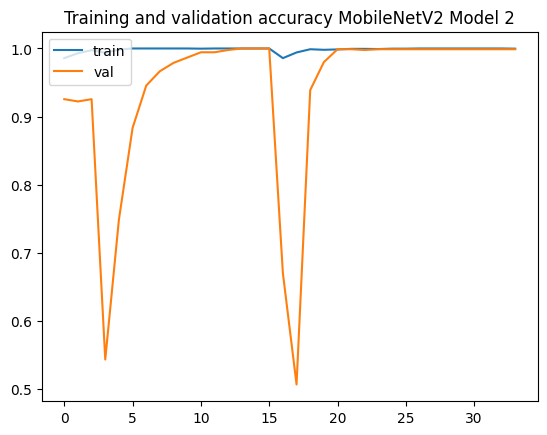

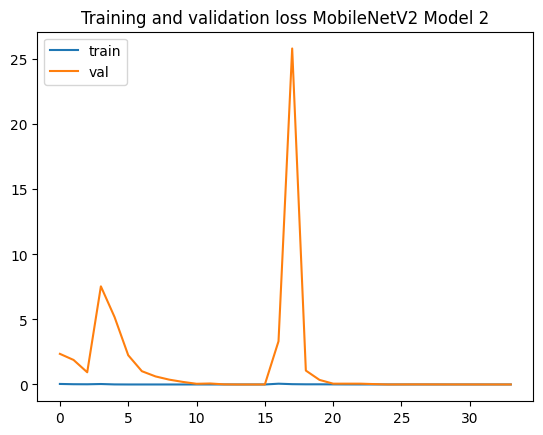

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [24]:
!zip -r /content/Strawberry_MobileNetV2_model2_Based_Non_Augmented.zip /content/Strawberry_MobileNetV2_model2_Based_Non_Augmented

  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Strawberry_MobileNetV2_model2_Based_Non_Augmented/saved_model.pb (deflated 91%)
